# Preprocessing

## Requisite Resources and Knowledge

Important libraries we will use is `spacy`, `pandas`, `networkx` and `matplotlib`. `spacy` is the NLP package that will handle the knowledge extraction that will feed into the subject, predicate, object (SPO) triples. `pandas` is used for creating a dataframe that contains the SPO triples which are used for graphing and statistical analysis. `networkx` and `matplotlib` are the primary sources of visual analysis of these knowledge graphs. To utilize these libraries effectively, we will need to be familiar with the resource description framework (RDF), parts of speech (POS) tagging, sentence segmenetation, dependency parsing, entity recognition & linking, SPO triples, and data engineering.

`bs4, requests` are supplementary libraries that are not used in this notebook but can be extremely useful when performing HTML/XML parsing and performing HTTP requests, respectfully.

`tqdm` is a library that creates a smart progress meter. It is unnecessary but useful when determing the progress made on an iterable and also estimation of time left.

## Loading Libraries

In [1]:
# !pip install spacy
# !python -m spacy download en_core_web_sm
import re
import pandas as pd
# import bs4
# import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

## Reading and Sampling the sample data

In [2]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [3]:
candidate_sentences['sentence'].sample(5)

3006                                           and it took 3 weeks to wrap up.
1120    in august 2013 he was declared india's most searched celebrity online.
256          prometheus  and alien: covenant  address extraterrestrial themes.
2717                                  the film was released on 6 january 2017.
2349                           cooper and tars are ejected from the tesseract.
Name: sentence, dtype: object

# Entities Extraction
Entities are the nodes of our Knowledge Graph (KG). We can extract a single word entity from a sentence with the help of parts of speech (POS) tags. The noun and proper nouns will be our entities. However, when an entity spans across multiple words we need to parse the dependency tree of the sentence. We can accomplish this by creating a rule to extract such entities: ***extract the subject/object along with its modifiers, compound words and also extract the punctuation marks between them.*** This isn't necessarily complete, but it is a good place to start. 

In [4]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... compound
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... pobj
d823 ... punct


The following function extracts the subject and object entities from the sentence as they are encountered.

In [5]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [6]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:22<00:00, 188.68it/s]


For most sentences, our function works. Below, we will see that the sentence `"We are working towards the future"` correctly outputs `['We', 'Future']` as the subject and object respectively.

In [7]:
get_entities("We are working towards the future")

['We', 'future']

However, there are sentences that deviate from what we expect, for example the sentence `"c. mackenzie, and craig vincent joined the cast."` should output something along the lines of `['c. mackenzie and craig vincent', 'cast']`:

In [8]:
print(candidate_sentences[6:7])
entity_pairs[6:7]

                                           sentence
6  c. mackenzie, and craig vincent joined the cast.


[['c. mackenzie', 'craig  cast']]

# Relation Extraction
Relations between entities are the edges of our KE. We can extract these  through an unsupervised manner, by using the grammar of the setences, i.e., identifying the ROOT POS tag in a sentence.

The following function extracts the relation of the sentence, which is the ROOT/predicate of the sentence. The [`Matcher()`](https://spacy.io/usage/rule-based-matching) function is part of the `spaCy` package and allows you to perform token-based matching.

In [9]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1",[pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [10]:
get_relation("John completed the task")

'completed'

In [11]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:23<00:00, 184.20it/s]


In [12]:
pd.Series(relations).value_counts()[:50]

is               348
was              283
released on       82
are               73
were              67
include           61
                  50
's                41
released          39
have              31
became            29
has               29
released in       26
become            26
composed by       26
included          22
produced          21
called            21
been              20
considered        19
used              18
had               18
be                16
made              16
received          15
went              14
scheduled         14
hired             14
wrote             13
introduced in     13
directed by       13
set               12
wanted            11
won               11
produced by       11
began             11
began in          11
\n                10
features          10
sold              10
cast as           10
written by        10
stars             10
gave              10
gives              9
includes           9
going              9
known as     

# Creating the Graph

In [13]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [14]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

In [15]:
# !pip install -U decorator
!pip install 'decorator == 5.0.7'

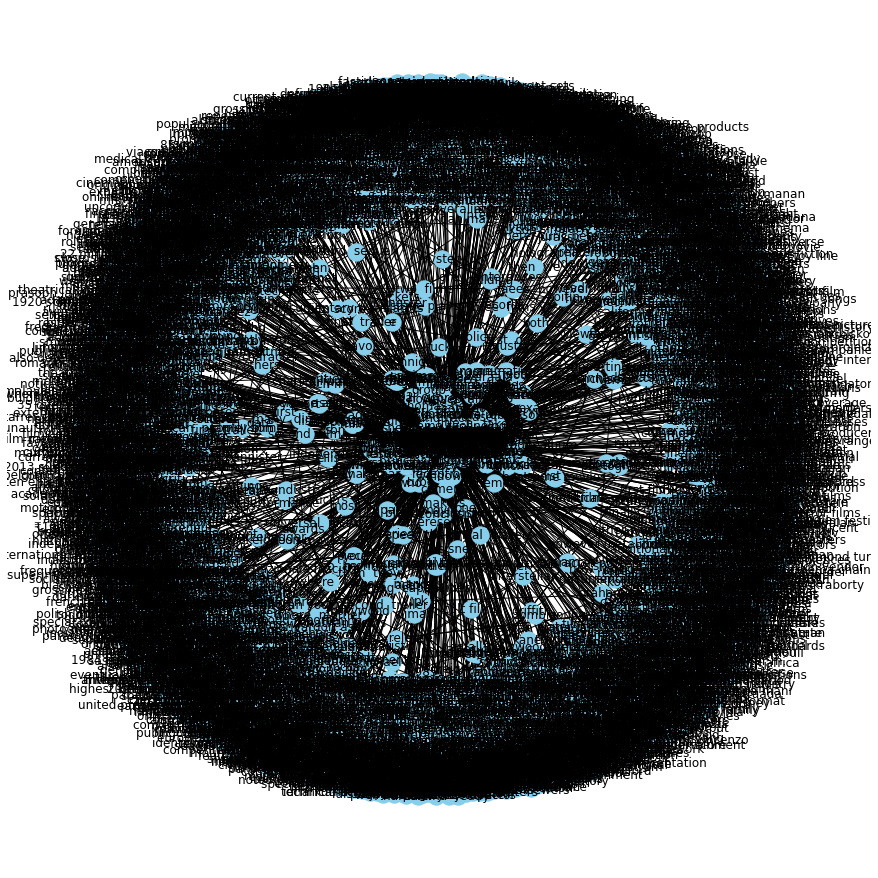

In [16]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

This is the entire knowledge graph with every single usage relation, however, this isn't useful for our understanding. We can single out certain relations of interest.

###### "composed by"

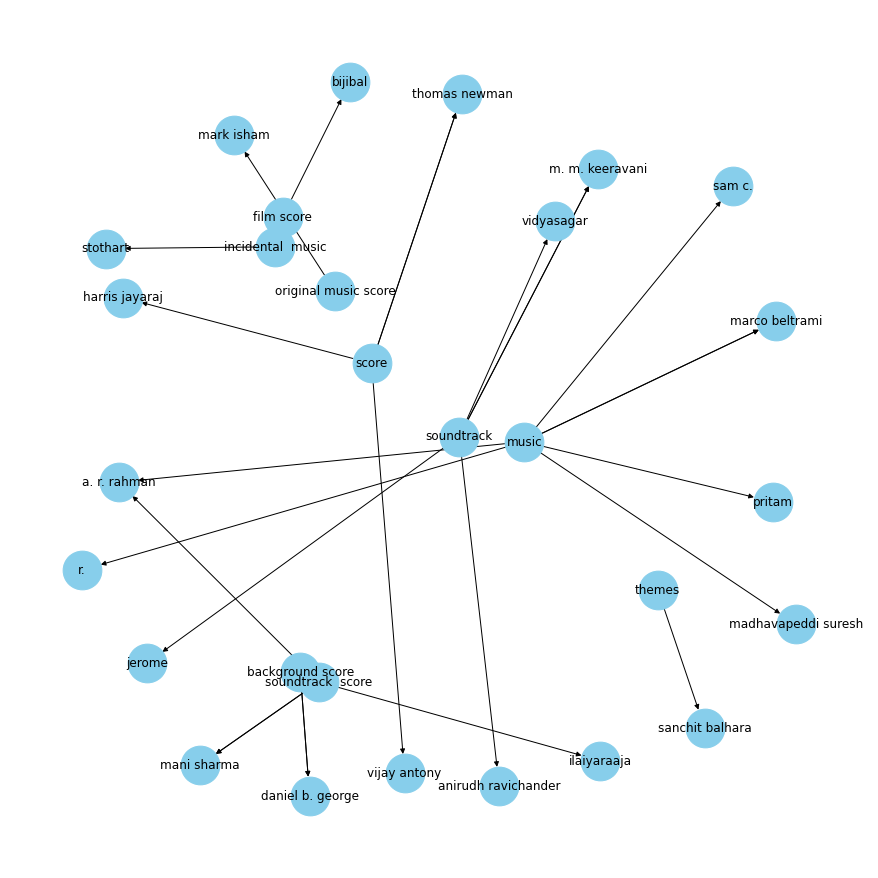

In [17]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

###### "written by"

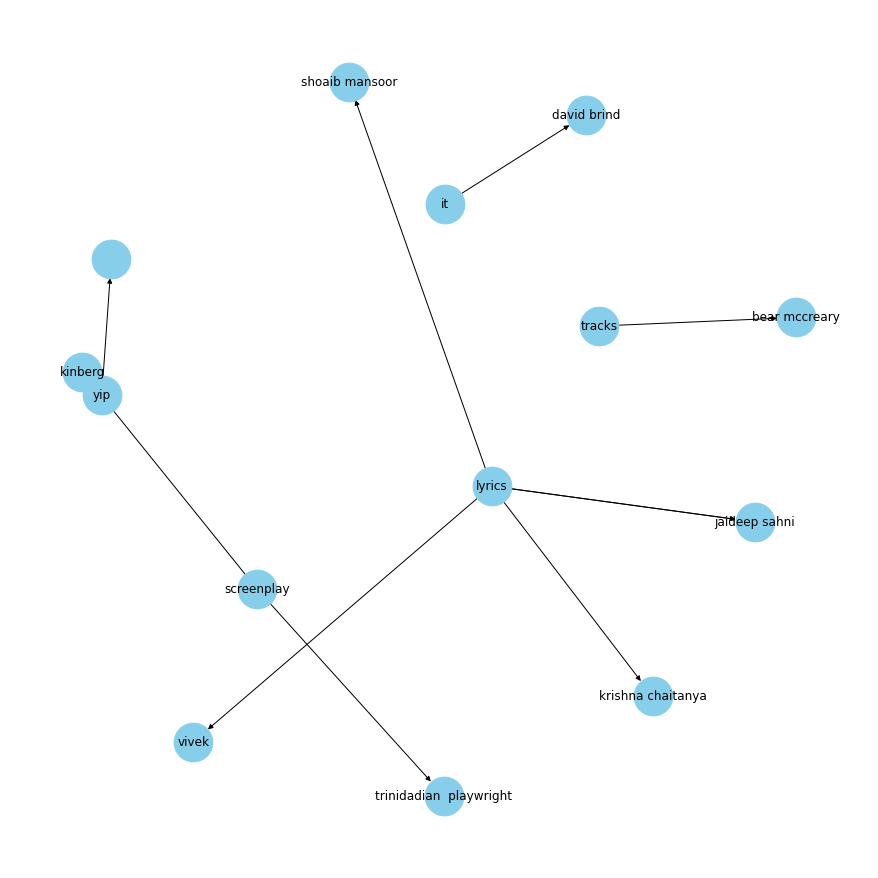

In [18]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

###### "released in"

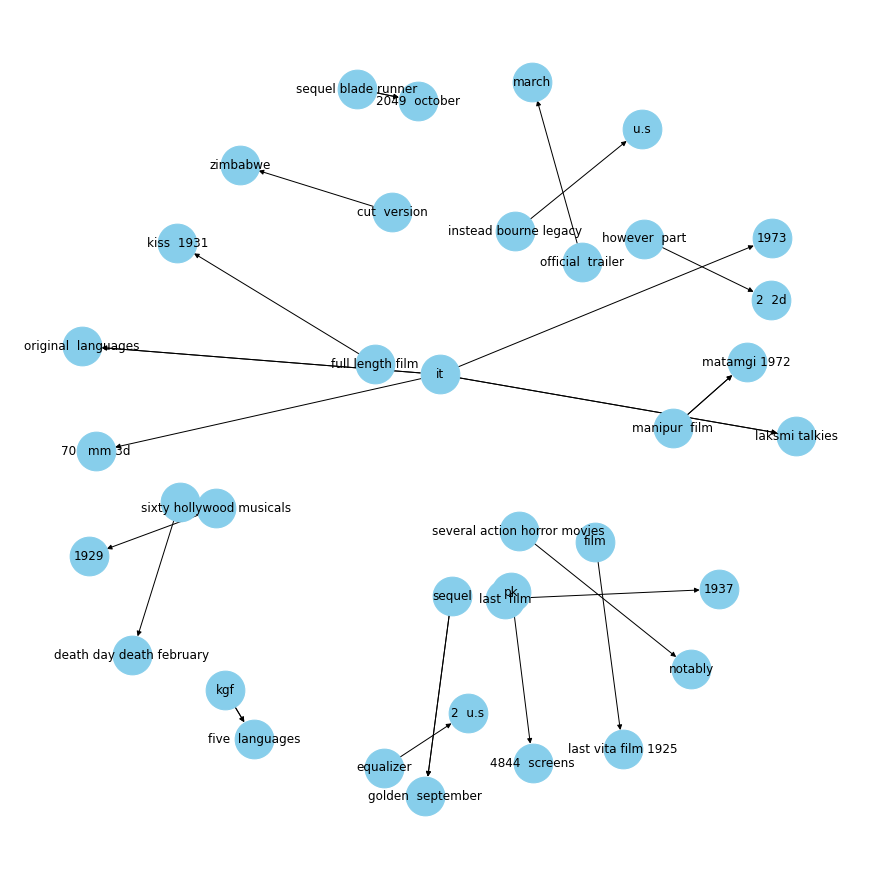

In [19]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

While these graphs are not perfect, i.e., 'it' as an entity does not provide much insight as to what it is referring to, we can still gleam a lot of useful information.

# Conclusion and Thoughts

1. One important thing to note is that our method of generating a knowledge graph is limited to sentence-level, which does not always provide complete knowledge extraction. There are many instances where entities can be referenced between sentences or even paragraphs.
2. The extraction rule we use "***extract the subject/object along with its modifiers, compound words and also extract the punctuation marks between them.***" isn't complete. For example, the sentence "Mark Zuckerberg is the CEO of Facebook" classifies 'Facebook' as the object, but 'CEO' is an important relation that is not picked up. This can be fixed by adding more rules.
3. We restricted ourselves to sentences with exactly two entities. Even so, we can still build an informative and complex networks.

# References

- [Knowledge Graph Tutorial](https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/)
- [Knowledge Graph Simple Understanding](https://medium.com/analytics-vidhya/a-knowledge-graph-implementation-tutorial-for-beginners-3c53e8802377)

## Support Links
- [Matcher.Add Issues](https://stackoverflow.com/questions/66164156/problem-with-using-spacy-matcher-matcher-matcher-add-method)
- [Markdown Support](https://www.markdownguide.org/basic-syntax/#lists-1)
- [networkx.decorator random_state_index error](https://stackoverflow.com/questions/66922359/unexpected-error-while-drawing-networkx-graph/66922837#66922837)